# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
data_path: str = "~/house/data"
train_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission: pd.DataFrame = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [3]:
# 금리, 지하철, 학교, 공원 정보 불러오기
interest_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
subway_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))
school_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
park_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))

# 데이터 병합

## 금리 데이터 병합
* `interest_data`: 2018년 12월 ~ 2024년 5월까지의 금리
* 계약 연월 기준으로 `interest_data`를 `train_data`로 병합 (2019년 4월 ~ 2023년 12월)
* 계약 연월 기준으로 `interest_data`를 `test_data`로 병합 (2024년 1월 ~ 2024년 6월)

In [4]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0


In [5]:
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34
...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14


In [6]:
interest_data

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


In [7]:
# 계약 연월 기준으로 interest_data를 train_data로 병합
merged_train = pd.merge(train_data, interest_data, left_on="contract_year_month", right_on="year_month", how="left")
merged_train = merged_train.drop(columns=["year_month"])
merged_train

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,1.78
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,1.26
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,1.26
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,1.68
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0,4.00
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0,4.00
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0,3.84
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0,3.84


In [8]:
merged_test = pd.merge(test_data, interest_data, left_on="contract_year_month", right_on="year_month", how="left")
merged_test = merged_test.drop(columns=["year_month"])
merged_test

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,3.54
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,3.54
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,3.54
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,3.56
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,NaN
...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,3.62
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,3.59
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,3.59
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,3.59


In [9]:
# 금리 결측치 개수 확인 (2024년 6월)
merged_test["interest_rate"].isnull().sum()

11882

## 최단거리 데이터 병합

### sklearn의 BallTree를 활용한 haversine 거리 계산 함수

In [10]:
def find_closest_distance_haversine(
    train_data: pd.DataFrame, 
    loc_df: pd.DataFrame
) -> pd.DataFrame:
    """건물과 지하철/학교/공원 사이의 haversine 거리를 계산하는 함수

    Args:
        train_data (pd.DataFrame): 학습(훈련) 또는 테스트 데이터프레임
        loc_df (pd.DataFrame): 위도, 경도를 column으로 갖는 데이터프레임

    Returns:
        pd.DataFrame: index, 위도, 경도, haversine 거리를 column으로 갖는 반환
    """
    # degree->radian 값으로 변환 for 삼각함수
    train_coords = np.radians(train_data[["latitude", "longitude"]].values)
    loc_coords = np.radians(loc_df[["latitude", "longitude"]].values)
    
    # Ball Tree 생성 
    tree = BallTree(loc_coords, metric="haversine")

    distances, indices = tree.query(train_coords, k=1) # 가까운 1 지점만 
    distances_meter = distances * 6371000 # 단위를 meter로 변환

    closest_coords = loc_df[["latitude", "longitude"]].iloc[indices.flatten()].values # 가까운 지점 좌표

    # index, 최단거리, 최단거리에 해당하는 지점의 위도, 경도로 이루어진 데이터프레임 생성
    result_df = pd.DataFrame({
        "index" : train_data.index,
        "closest_distance" : distances_meter.flatten(),
        "closest_latitude" : closest_coords[:, 0],
        "closest_longitude" : closest_coords[:, 1]
    })

    return result_df


In [11]:
# 중복 행 추출
unique_loc_train = train_data[["latitude", "longitude"]].drop_duplicates().reset_index(drop=True)
unique_loc_test = test_data[["latitude", "longitude"]].drop_duplicates().reset_index(drop=True)

### subway 병합

In [12]:
subway_result_train = find_closest_distance_haversine(unique_loc_train, subway_data)
subway_result_train = pd.concat([subway_result_train, unique_loc_train], axis=1)
subway_result_train.drop("index", axis=1, inplace=True)
train_data = pd.merge(train_data, subway_result_train, on=["latitude", "longitude"], how="left")
train_data.rename(columns={"closest_distance": "nearest_subway_distance",
                           "closest_latitude": "nearest_subway_latitude",
                           "closest_longitude": "nearest_subway_longitude"}, inplace=True)

In [13]:
subway_result_test = find_closest_distance_haversine(unique_loc_test, subway_data)
subway_result_test = pd.concat([subway_result_test, unique_loc_test], axis=1)
subway_result_test.drop("index", axis=1, inplace=True)
test_data = pd.merge(test_data, subway_result_test, on=["latitude", "longitude"], how="left")
test_data.rename(columns={"closest_distance": "nearest_subway_distance",
                           "closest_latitude": "nearest_subway_latitude",
                           "closest_longitude": "nearest_subway_longitude"}, inplace=True)

### school 병합

In [14]:
school_result_train = find_closest_distance_haversine(unique_loc_train, school_data)
school_result_train = pd.concat([school_result_train, unique_loc_train], axis=1)
school_result_train.drop("index", axis=1, inplace=True)
train_data = pd.merge(train_data, school_result_train, on=["latitude", "longitude"], how="left")
train_data.rename(columns={"closest_distance": "nearest_school_distance",
                           "closest_latitude": "nearest_school_latitude",
                           "closest_longitude": "nearest_school_longitude"}, inplace=True)

In [15]:
school_result_test = find_closest_distance_haversine(unique_loc_test, school_data)
school_result_test = pd.concat([school_result_test, unique_loc_test], axis=1)
school_result_test.drop("index", axis=1, inplace=True)
test_data = pd.merge(test_data, school_result_test, on=["latitude", "longitude"], how="left")
test_data.rename(columns={"closest_distance": "nearest_school_distance",
                           "closest_latitude": "nearest_school_latitude",
                           "closest_longitude": "nearest_school_longitude"}, inplace=True)

### park 병합

In [16]:
park_result_train = find_closest_distance_haversine(unique_loc_train, park_data)
park_result_train = pd.concat([park_result_train, unique_loc_train], axis=1)
park_result_train.drop("index", axis=1, inplace=True)
train_data = pd.merge(train_data, park_result_train, on=["latitude", "longitude"], how="left")
train_data.rename(columns={"closest_distance": "nearest_park_distance",
                           "closest_latitude": "nearest_park_latitude",
                           "closest_longitude": "nearest_park_longitude"}, inplace=True)

In [17]:
park_result_test = find_closest_distance_haversine(unique_loc_test, park_data)
park_result_test = pd.concat([park_result_test, unique_loc_test], axis=1)
park_result_test.drop("index", axis=1, inplace=True)
test_data = pd.merge(test_data, park_result_test, on=["latitude", "longitude"], how="left")
test_data.rename(columns={"closest_distance": "nearest_park_distance",
                           "closest_latitude": "nearest_park_latitude",
                           "closest_longitude": "nearest_park_longitude"}, inplace=True)

## 병합한 데이터 확인

In [18]:
on = merged_train.columns.drop("interest_rate").tolist() # 병합 기준이 될 column 리스트
train_data = pd.merge(merged_train, train_data, on=on, how="left")
# train_data = train_data.drop(columns=["index"])
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,...,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longitude,nearest_school_distance,nearest_school_latitude,nearest_school_longitude,nearest_park_distance,nearest_park_latitude,nearest_park_longitude
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,...,1.78,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,...,1.26,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,...,1.26,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,...,1.68,3897.279708,36.990726,127.085159,214.559689,36.962943,127.056980,169.839678,36.963502,127.054582
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,...,1.85,2039.685349,36.990726,127.085159,1708.489263,36.987746,127.085154,382.401815,36.971743,127.088742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,...,4.00,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,...,4.00,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,...,3.84,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,...,3.84,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891


In [19]:
on = merged_test.columns.drop("interest_rate").tolist() # 병합 기준이 될 column 리스트
test_data = pd.merge(merged_test, test_data, on=on, how="left")
# test_data = test_data.drop(columns=["index"])
test_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longitude,nearest_school_distance,nearest_school_latitude,nearest_school_longitude,nearest_park_distance,nearest_park_latitude,nearest_park_longitude
0,0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,3.54,4284.771362,36.990726,127.085159,779.057020,36.962943,127.056980,288.442840,36.964653,127.045679
1,1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,3.54,5004.558790,36.990726,127.085159,1448.494091,36.962943,127.056980,153.733042,36.961730,127.040502
2,2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,3.54,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
3,3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,3.56,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
4,4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,NaN,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,3.62,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150168,150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150169,150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150170,150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891


# Data Preprocessing

In [20]:
# 위치 중복도 낮은 행 삭제
groups = train_data.groupby(["latitude", "longitude"])["index"].count()
conditioned_groups_index = groups[(groups >= 2) & (groups <= 5)].index # 이 범위를 파라미터로 조정하는걸로
small_groups = train_data[
    train_data["latitude"].isin(conditioned_groups_index.get_level_values(0)) &
    train_data["longitude"].isin(conditioned_groups_index.get_level_values(1))
]
train_data.drop(small_groups.index, axis=0, inplace=True)

In [21]:
# built_year > 2024 행 삭제
print("before train :", train_data.shape)
train_data = train_data[train_data["built_year"] < 2024]
train_data.reset_index(drop=True, inplace=True)
print("after train :", train_data.shape)

before train : (1790217, 21)
after train : (1790125, 21)


In [22]:
train_data["built_year"]

0          2019
1          2019
2          2019
3          1995
4          2016
           ... 
1790120    2010
1790121    2010
1790122    2010
1790123    2010
1790124    2010
Name: built_year, Length: 1790125, dtype: int64

# Feature Engineering

In [23]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

### 1. log 변환

In [24]:
train_data["log_deposit"] = np.log1p(train_data["deposit"])
train_data["log_area_m2"] = np.log1p(train_data["area_m2"])
train_data["log_school_distance"] = np.log1p(train_data["nearest_school_distance"])
train_data["log_park_distance"] = np.log1p(train_data["nearest_park_distance"])
train_data["log_subway_distance"] = np.log1p(train_data["nearest_subway_distance"])

In [25]:
test_data["log_area_m2"] = np.log1p(test_data["area_m2"])
test_data["log_school_distance"] = np.log1p(test_data["nearest_school_distance"])
test_data["log_park_distance"] = np.log1p(test_data["nearest_park_distance"])
test_data["log_subway_distance"] = np.log1p(test_data["nearest_subway_distance"])

### 2. Feature Select

In [26]:
# 피처 및 타겟 설정
train_cols = [
    "deposit",
    "log_deposit",
    "log_area_m2",
    "built_year",
    "latitude",
    "longitude",
    "log_subway_distance",
    "log_school_distance",
    "log_park_distance",
    "contract_year_month",
    "contract_day"
]
train_data = train_data[train_cols]

In [27]:
# 피처 및 타겟 설정
test_cols = [
    "log_area_m2",
    "built_year",
    "latitude",
    "longitude",
    "log_subway_distance",
    "log_school_distance",
    "log_park_distance",
    "contract_year_month",
    "contract_day"
]
test_data = test_data[test_cols]

### 3. 데이터 분리

In [28]:
X = train_data.drop(columns=["deposit", "log_deposit"], inplace=False)
y = train_data[["deposit", "log_deposit"]]

# Modeling

In [35]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1, log=True),
        "gamma": trial.suggest_float("gamma", 0.01, 1, log=True)
    }

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    mae = []
    for train_idx, valid_idx in kfold.split(X, train_data["deposit"]):
        X_train, y_train = X.loc[train_idx, :], y.loc[train_idx, "log_deposit"]
        X_valid, y_valid = X.loc[valid_idx, :], y.loc[valid_idx, "deposit"]
        best_model = xgb.XGBRegressor(**params, tree_method="gpu_hist", gpu_id=0, random_state=42)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_valid)
        y_pred = np.expm1(y_pred)
        mae.append(mean_absolute_error(y_valid, y_pred))

    return np.mean(mae)

In [37]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=42), direction="minimize")
study.optimize(objective, n_trials=100)

print(f"Best score of XGB: {study.best_value:.4f}")
print("  Parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value:.4f}")

[I 2024-10-12 11:39:15,661] A new study created in memory with name: no-name-8bf0cb66-4838-4942-9edb-980e0f852b88
[I 2024-10-12 11:39:48,383] Trial 0 finished with value: 4622.165583891079 and parameters: {'n_estimators': 406, 'learning_rate': 0.4123206532618726, 'max_depth': 8, 'subsample': 0.7571539027086853, 'gamma': 0.020513382630874502}. Best is trial 0 with value: 4622.165583891079.
[I 2024-10-12 11:40:16,825] Trial 1 finished with value: 6950.039237205378 and parameters: {'n_estimators': 198, 'learning_rate': 0.012551115172973842, 'max_depth': 9, 'subsample': 0.7584442335012195, 'gamma': 0.2607024758370766}. Best is trial 0 with value: 4622.165583891079.
[I 2024-10-12 11:40:30,473] Trial 2 finished with value: 4954.780067950162 and parameters: {'n_estimators': 69, 'learning_rate': 0.44447541666908114, 'max_depth': 9, 'subsample': 0.5792825495506346, 'gamma': 0.02310201887845294}. Best is trial 0 with value: 4622.165583891079.
[I 2024-10-12 11:40:48,907] Trial 3 finished with val

Best score of XGB: 4571.7110
  Parameters:
    n_estimators: 572.0000
    learning_rate: 0.0563
    max_depth: 10.0000
    subsample: 0.6377
    gamma: 0.0171


# Inference

In [39]:
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, random_state=42, tree_method="gpu_hist", gpu_id=0)
best_model.fit(X, y["log_deposit"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.017144863541673258, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05625317995190389, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=572, n_jobs=None,
             num_parallel_tree=None, ...)

In [40]:
y_test_log = best_model.predict(test_data)
y_test = np.expm1(y_test_log) # 지수변환 (로그변환의 역변환)

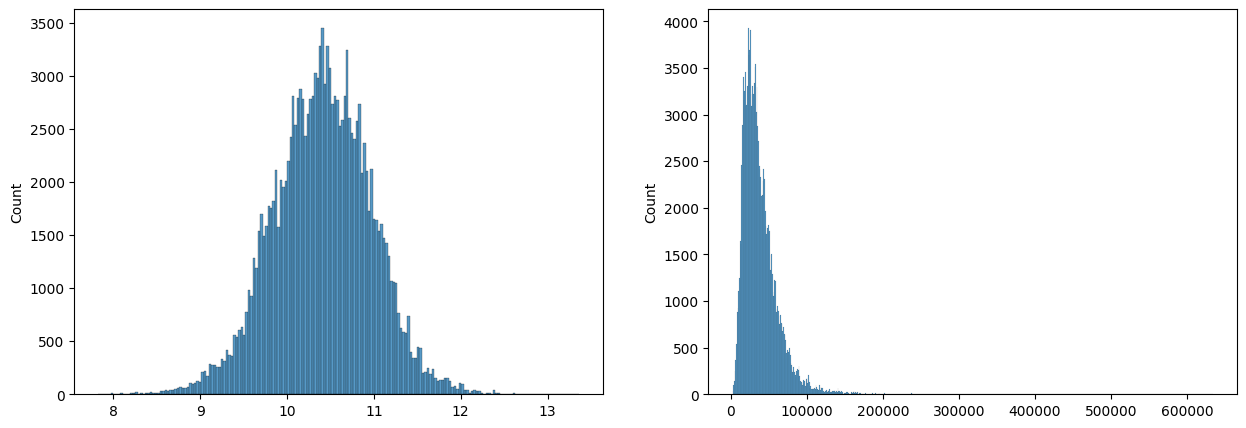

In [41]:
# 지수변환 전/후 예측값 히스토그램 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_test_log, ax=axes[0])
sns.histplot(y_test, ax=axes[1])
plt.show()

In [42]:
sample_submission["deposit"] = y_test
sample_submission.to_csv("output.csv", index=False)